In [1]:
import os
import cv2
import math
import time
import tarfile
import numbers
import threading
import queue as Queue
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
#from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, DataLoader, Dataset
from torchsummary import summary

In [2]:
import mxnet as mx
from mxnet import recordio

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
random_seed = 42
torch.manual_seed(random_seed);

In [5]:
torch.set_printoptions(edgeitems=5)

In [6]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [7]:
device = get_default_device()

In [8]:
device

device(type='cuda')

In [9]:
class CosFace(torch.nn.Module):
    def __init__(self, s=64.0, m=0.40):
        super(CosFace, self).__init__()
        self.s = s
        self.m = m

    def forward(self, logits, labels):
        index = torch.where(labels != -1)[0]
        target_logit = logits[index, labels[index].view(-1)]
        final_target_logit = target_logit - self.m
        logits[index, labels[index].view(-1)] = final_target_logit
        logits = logits * self.s
        return logits

In [10]:
class CosFace(nn.Module):
    def __init__(self, in_features, out_features, s=64.0, m=0.35):
        super(CosFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.kernel = nn.Parameter(torch.FloatTensor(in_features, out_features))
        nn.init.normal_(self.kernel, std=0.01)

    def forward(self, logits, labels):
        logits = l2_norm(logits, axis=1)
        kernel_norm = l2_norm(self.kernel, axis=0)
        cos_theta = torch.mm(logits, kernel_norm)
        cos_theta = cos_theta.clamp(-1, 1)  # for numerical stability
        index = torch.where(label != -1)[0]
        m_hot = torch.zeros(index.size()[0], cos_theta.size()[1])
        m_hot.scatter_(1, labels[index, None], self.m)
        cos_theta[index] -= m_hot
        ret = cos_theta * self.s
        return ret

In [11]:
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [12]:
def conv_2d(ni, nf, ks, stride=1):
    return nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=ks, stride=stride, padding=ks//2, bias=False)

def bn_relu_conv(ni, nf, ks):
    return nn.Sequential(nn.BatchNorm2d(ni), 
                       nn.ReLU(inplace=True),
                       conv_2d(ni, nf, ks))

In [13]:
class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        if ni > 100:
            temp = ni * 2
        else:
            temp = ni
        self.bn = nn.BatchNorm2d(temp)
        self.conv1 = conv_2d(temp, ni, 1, stride)
        self.conv2 = bn_relu_conv(ni, ni, ks=3)
        self.conv3 = bn_relu_conv(ni, nf, ks=1)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(temp, nf, 1, stride)

    def forward(self, x):
        #print("Inside Res Block1")
        #print(x.shape)
        x = F.relu(self.bn(x), inplace=True)
        #print(x.shape)
        r1 = self.shortcut(x)
        #print(r1.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) * 0.2
        #print(x.shape)
        return x.add_(r1)

In [14]:
class ResBlock2(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, 1, stride)
        self.conv2 = bn_relu_conv(nf, nf, ks=3)
        self.conv3 = bn_relu_conv(nf, ni, ks=1)
        self.shortcut = lambda x: x
#        if ni != nf:
#            self.shortcut = conv_2d(ni, nf, 1, 1)

    def forward(self, x):
        #print("Inside Res Block2")
        #print(x.shape)
        x = F.relu(self.bn(x), inplace=True)
        #print(x.shape)
        r = self.shortcut(x)
        #print(r.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) * 0.2
        return x.add_(r)

In [15]:
def make_group(N, ni, nf, stride):
    start = ResBlock(ni, nf, stride)
    rest = [ResBlock2(nf, ni) for j in range(1, N)]
    return [start] + rest

In [16]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x.view(x.size(0), -1)

In [17]:
class MyResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=64):
        super().__init__()
        #Increase channels
        layers = [conv_2d(3, 64, ks=7, stride=2)]
        layers += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
        n_channels = [n_start]

        #Add groups
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            layers += make_group(N[i], n_channels[i], n_channels[i]*4, stride)

        #Pool, Flatten, and add linear layer for classification  
        layers += [nn.BatchNorm2d(n_channels[n_groups]*2),
                   nn.ReLU(inplace=True),
                   nn.AdaptiveAvgPool2d(1),
                   #nn.AvgPool2d(kernel_size=2, stride=2), 
                   Flatten(), 
                   nn.Linear(n_channels[n_groups]*2, n_classes)]
    
        self.features = nn.Sequential(*layers)
        
    def forward(self, x):
        #a = self.features(x)
        #print(a.shape)
        return self.features(x)

In [18]:
#Number of blocks at various groups
N_50 = [3, 4, 6, 3]
N_101 = [3, 4, 23, 3]
N_152 = [3, 8, 36, 3]

def ResNet50(n_classes):
    return MyResNet(4, N_50, n_classes, k=2)

def ResNet101(n_classes):
    return MyResNet(4, N_101, n_classes, k=2)

def ResNet152(n_classes):
    return MyResNet(4, N_152, n_classes, k=2)

In [19]:
test_model = ResNet50(10)

In [20]:
test_model

MyResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv3): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): ResBlock2(
      (bn): 

In [21]:
def test():
    net = ResNet50(10)
    x = torch.randn(2, 3, 112, 300)
    y = net(x)
    print(y.shape)

In [22]:
test()

torch.Size([2, 10])


In [23]:
class ResNet_WIP(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=64):
        super().__init__()
        #Increase channels
        self.layers = [conv_2d(3, 64, ks=7, stride=2)]
        self.layers += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
        n_channels = [n_start]

        #Add groups
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            self.layers += self.make_group(N[i], n_channels[i], n_channels[i]*4, stride)

        #Pool, Flatten, and add linear layer for classification  
        self.layers += [nn.BatchNorm2d(n_channels[n_groups]*2),
                   nn.ReLU(inplace=True),
                   nn.AdaptiveAvgPool2d(1),
                   #nn.AvgPool2d(kernel_size=2, stride=2), 
                   Flatten(), 
                   nn.Linear(n_channels[n_groups]*2, n_classes)]
                   #nn.Softmax(dim=1)]
    
        self.features = nn.Sequential(*self.layers)
        
    def forward(self, x):
        return self.features(x)

    def make_group(self, N, ni, nf, stride):
        start = ResBlock(ni, nf, stride)
        rest = [ResBlock2(nf, ni) for j in range(1, N)]
        return [start] + rest

# MS1M-ArcFace dataset

In [24]:
class ArcFaceDataset(Dataset):
    def __init__(self, root_dir):
        super(ArcFaceDataset, self).__init__()

        self.transform = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
             ])
        
        self.root_dir = root_dir
        #root_dir2 = "D:/Face/faces_emore/" #"faces_emore/"
        
        path_imgrec = os.path.join(root_dir, 'train.rec')
        path_imgidx = os.path.join(root_dir, 'train.idx')
        self.imgrec = mx.recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')
        s = self.imgrec.read_idx(0)
        header, _ = mx.recordio.unpack(s)
        
        if header.flag > 0:
            self.header0 = (int(header.label[0]), int(header.label[1]))
            self.imgidx = np.array(range(1, int(header.label[0])))
        else:
            self.imgidx = np.array(list(self.imgrec.keys)) #List of numbers 1 .... 5908396

    def __getitem__(self, index):
        idx = self.imgidx[index]
        s = self.imgrec.read_idx(idx)
        header, img = mx.recordio.unpack(s)
        label = header.label
        if not isinstance(label, numbers.Number):
            label = label[0]
        label = torch.tensor(label, dtype=torch.long)
        sample = mx.image.imdecode(img).asnumpy()
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, label

    def __len__(self):
        return len(self.imgidx)

In [25]:
root_dir1 = "../faces_emore/" #For Ubuntu
root_dir2 = "D:/Face/faces_emore/" #For Windows

dataset = ArcFaceDataset(root_dir1)

In [26]:
dataset

In [27]:
len(dataset)

5822653

In [28]:
img, label = dataset[100]
print(img.shape, label)

img = torch.reshape(img, (112, 112, 3))
print(img.shape)

torch.Size([3, 112, 112]) tensor(0)
torch.Size([112, 112, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'label = 0')

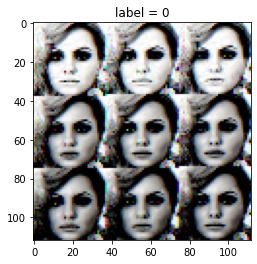

In [29]:
plt.imshow(img)
plt.title('label = ' + str(label.item()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'label = 47306')

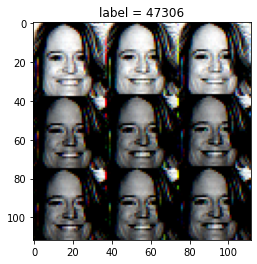

In [30]:
img, label = dataset[3303598]
img = torch.reshape(img, (112, 112, 3))

plt.imshow(img)
plt.title('label = ' + str(label.item()))

In [31]:
#Limiting the dataset for computation purposes

lim_factor = 1 #Set to 1 for using the entire dataset
lim_size = int(lim_factor * len(dataset))
lim_dataset_size = len(dataset) - lim_size

large_ds, lim_ds = random_split(dataset, [lim_dataset_size, lim_size])

In [32]:
len(large_ds), len(lim_ds)

(0, 5822653)

In [33]:
test_factor = 0.1
test_size = int(test_factor * len(lim_ds))
train_size = len(lim_ds) - test_size
train_ds, test_ds = random_split(lim_ds, [train_size, test_size])

val_factor = 0.1
val_size = int(val_factor * len(lim_ds))
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

In [34]:
len(train_ds), len(val_ds), len(test_ds)

(4658123, 582265, 582265)

In [35]:
batch_size=256

In [36]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=3, pin_memory=True)

In [37]:
train_dl

In [38]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [39]:
model = ResNet50(85742)

In [40]:
to_device(model, device)

MyResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv3): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): ResBlock2(
      (bn): 

In [41]:
summary(model, input_size = (3, 112, 112), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           9,408
         MaxPool2d-2           [-1, 64, 28, 28]               0
       BatchNorm2d-3           [-1, 64, 28, 28]             128
            Conv2d-4          [-1, 256, 28, 28]          16,384
            Conv2d-5           [-1, 64, 28, 28]           4,096
       BatchNorm2d-6           [-1, 64, 28, 28]             128
              ReLU-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]          36,864
       BatchNorm2d-9           [-1, 64, 28, 28]             128
             ReLU-10           [-1, 64, 28, 28]               0
           Conv2d-11          [-1, 256, 28, 28]          16,384
         ResBlock-12          [-1, 256, 28, 28]               0
      BatchNorm2d-13          [-1, 256, 28, 28]             512
           Conv2d-14           [-1, 64,

In [42]:
len(train_dl), len(val_dl), len(test_dl)

(18196, 2275, 2275)

In [43]:
for images, labels in test_dl:
    #print("Inside")
    print('images.shape:', images.shape)
    print('labels.shape:', labels.shape)
    print('labels:', labels)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    print('out[0].shape:', out[0].shape)
    
    pre_sum = torch.sum(out, dim=1) #torch.sum(out[0], dim=0)
    print('sum of out[0]:', pre_sum.shape)
    
    F_sum = torch.sum(F.softmax(out, dim=1), dim=1)
    print('softmax of out[0]:', F_sum.shape)
    break

images.shape: torch.Size([256, 3, 112, 112])
labels.shape: torch.Size([256])
labels: tensor([47306, 16381, 49841, 27966, 84653, 71918, 54165,  6124,  5710, 71651,
        59062, 69586,  9590, 34991, 11964, 20897, 55237, 58097, 79477,  7502,
         2544,  6624, 31884, 77098, 81669, 43510, 49673, 32396, 61747, 62899,
         1594, 68958, 32263, 10778, 47138, 85081, 78686,  3101, 51000, 33270,
        11309, 52863, 55272, 74350, 26636,  7106,  2102,   680,  4844, 30212,
        67503,  3961, 10091, 18373, 16888,  2911, 56027, 67352, 21712, 62939,
        66523, 20987, 36556, 66073, 23727, 39938,  9384, 28674, 34193, 81304,
         8870,  9233, 49562, 18042, 59057, 15205, 62900, 56374, 59013, 36457,
        37743, 85595,  4211, 52031, 85290,  7335, 85269, 65098, 58144, 26076,
        30060, 47488,  1844, 74412, 19114, 51725, 72351, 65100,  3651, 71932,
        18304,  8939, 22381, 33674, 55553, 28436,  4884, 60275,  8285, 10757,
        62016, 85570,   677, 17267, 57224, 78850, 42029, 

In [44]:
a = torch.Tensor([1, 34, 2]) #torch.ones(4)
a[0].shape, a.shape, a

(torch.Size([]), torch.Size([3]), tensor([ 1., 34.,  2.]))

In [45]:
b = torch.sum(a)
b

tensor(37.)

In [46]:
c = F.softmax(a, dim=0)
c

tensor([4.6589e-15, 1.0000e+00, 1.2664e-14])

In [47]:
# d = F.softmax(d, dim=0)
# d

In [48]:
torch.sum(c, dim=0)

tensor(1.)

In [49]:
actual_labels = torch.zeros(256, 85742)

c = 0
for i in labels:
    actual_labels[c][int(i)] = 1
    c+=1

In [50]:
actual_labels.shape

torch.Size([256, 85742])

In [51]:
actual_labels[5][4966]

tensor(0.)

In [52]:
actual_labels[5]

tensor([0., 0., 0., 0., 0.,  ..., 0., 0., 0., 0., 0.])

In [53]:
temp_loss_func = F.binary_cross_entropy #nn.CrossEntropyLoss()

In [54]:
# for xb, yb in val_dl:
#     print(xb.shape, yb.shape)
#     temp_preds = model(xb)
#     print(temp_preds.shape)
#     temp_loss = temp_loss_func(temp_preds, yb)
#     print(temp_loss)
#     break

In [55]:
# a = torch.Tensor([1, 0, 0]) #torch.zeros(256, 85742) #
# b = torch.Tensor([1, 0, 0]) #torch.zeros(256) #

# c = temp_loss_func(a, b)
# c

In [56]:
print(a.shape, b.shape)

torch.Size([3]) torch.Size([])


In [57]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    #Generate predictions
    preds = model(xb)
    #Calculate loss
    loss = loss_func(preds, yb)
    
    if opt is not None:
        #Compute gradients
        loss.backward()
        #update parameters
        opt.step()
        #Reset Gradients
        opt.zero_grad()

    metric_result = None
    if metric is not None:
        #compute the metric
        metric_result = metric(preds, yb)
        
    return loss.item(), len(xb), metric_result

In [58]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        #pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        #separate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        #Total size of the dataset
        total = np.sum(nums)
        #Avg. loss across batches
        avg_loss = np.sum(np.multiply(losses, nums))/total
        avg_metric = None
        
        if metric is not None:
            #Avg of metric across batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total

    return avg_loss, total, avg_metric

In [59]:
def fit(epochs, model, loss_fn, train_dl, valid_dl, lr=None, metric=None, opt_fn=None):
    
    train_losses, val_losses, val_metrics = [], [], []
    
    #instantiate the optimizer
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        start = time.time()
        #Training
        model.train()
        for xb, yb in train_dl:
            train_loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt)

        #Evaluation
        model.eval()
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result

        #Record the loss and metric
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)
        
        end = time.time()

        #Print progress:
        if metric is None:
            print('Epoch [{}/{}], Train_loss: {:.4f}, Val_loss: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss))
            print(str(round((end - start), 2)) + " secs")
        
        else:
            print('Epoch [{}/{}], Train_loss: {:.4f}, Val_loss: {:.4f}, {}: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss, metric.__name__, val_metric))
            print(str(round((end - start), 2)) + " secs")

    return train_losses, val_losses, val_metrics

In [60]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [61]:
val_loss, _, val_acc = evaluate(model, F.cross_entropy, val_dl, metric=accuracy) #metric=accuracy #metric=None

In [62]:
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))
#print('Loss: {:.4f}'.format(val_loss))

Loss: 11.3871, Accuracy: 0.0000


In [63]:
num_epochs = 18
opt_func = torch.optim.Adam
lr = 0.005

In [64]:
history = fit(num_epochs, model, F.cross_entropy, train_dl, val_dl, lr, accuracy, opt_func)

Epoch [1/18], Train_loss: 4.2555, Val_loss: 4.5002, accuracy: 0.2530
3978.88 secs
Epoch [2/18], Train_loss: 1.3822, Val_loss: 1.7916, accuracy: 0.6602
3973.64 secs
Epoch [3/18], Train_loss: 0.9583, Val_loss: 1.1819, accuracy: 0.7670
3973.68 secs
Epoch [4/18], Train_loss: 0.7099, Val_loss: 0.8760, accuracy: 0.8264
3978.73 secs
Epoch [5/18], Train_loss: 0.4520, Val_loss: 0.7689, accuracy: 0.8564
3972.56 secs
Epoch [6/18], Train_loss: 0.3978, Val_loss: 0.6419, accuracy: 0.8742
3973.76 secs
Epoch [7/18], Train_loss: 0.2615, Val_loss: 0.5794, accuracy: 0.8863
3973.06 secs
Epoch [8/18], Train_loss: 0.2462, Val_loss: 0.5303, accuracy: 0.8998
3972.34 secs
Epoch [9/18], Train_loss: 0.2078, Val_loss: 0.5219, accuracy: 0.9031
3969.21 secs
Epoch [10/18], Train_loss: 0.3939, Val_loss: 0.5874, accuracy: 0.8894
3971.59 secs
Epoch [11/18], Train_loss: 0.0981, Val_loss: 0.5014, accuracy: 0.9093
3973.64 secs
Epoch [12/18], Train_loss: 0.1421, Val_loss: 0.5015, accuracy: 0.9123
3973.7 secs
Epoch [13/18],

In [65]:
train_losses, val_losses, val_metrics = history

In [66]:
def plot_accuracies(val_metrics):
    #accuracies = [x['val_metrics'] for x in history]
    plt.plot(val_metrics, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

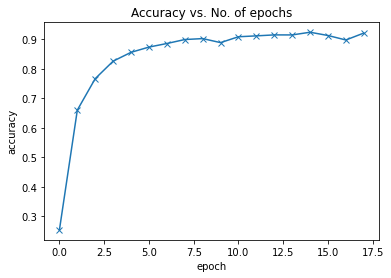

In [67]:
plot_accuracies(val_metrics)

In [68]:
def plot_losses(train_losses, val_losses):
    #train_losses = [x.get('train_losses') for x in history]
    #val_losses = [x['val_losses'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

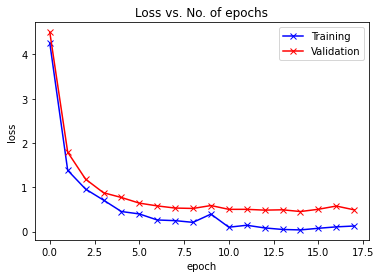

In [69]:
plot_losses(train_losses, val_losses)

In [70]:
result = evaluate(model, F.cross_entropy, test_dl, accuracy)
result

(0.49392071146031974, 582265, 0.9211716314736417)

In [71]:
torch.save(model.state_dict(), 'el_13-02.pth')

In [72]:
import pandas as pd

# Creating a new data frame
newDataframe = pd.DataFrame()

newDataframe['Train Loss'] = train_losses
newDataframe['Val Loss'] = val_losses
newDataframe['Val Acc.'] = val_metrics

# Converting the data frame to an excel file
newDataframe.to_excel('model_outputs.xlsx', index = False)

# Reading the data from the outputExcelFile
excelData = pd.read_excel('model_outputs.xlsx')

#Printing the data frame
print(excelData)

    Train Loss  Val Loss  Val Acc.
0     4.255539  4.500174  0.253033
1     1.382169  1.791600  0.660172
2     0.958268  1.181875  0.767041
3     0.709859  0.875954  0.826409
4     0.452046  0.768950  0.856406
5     0.397822  0.641855  0.874215
6     0.261495  0.579401  0.886349
7     0.246204  0.530296  0.899846
8     0.207770  0.521897  0.903080
9     0.393925  0.587380  0.889413
10    0.098066  0.501449  0.909323
11    0.142067  0.501476  0.912330
12    0.081921  0.483592  0.915628
13    0.047043  0.491073  0.915518
14    0.036909  0.451834  0.924648
15    0.073690  0.503087  0.913579
16    0.105719  0.575987  0.898352
17    0.125345  0.490359  0.921831


In [73]:
def create_list():
    img_list = []
    #%% 1 ~ 5908396, or 0~5908395, #85742 identities
    
    for i in range(5822653):
        header, s = recordio.unpack(imgrec.read_idx(i+1))
        img_list.append(header.label)
        
    lst = np.array(img_list)
    
    return lst

In [74]:
lst = create_list()
len(lst)

NameError: name 'imgrec' is not defined

In [75]:
def fetch_pred_image(lst, idx):
    idxs = np.where(lst==idx)[0]
    
    #img, label = dataset[idxs[-1]]
    
    header, s = recordio.unpack(imgrec.read_idx(idxs[-1]))
    img = mx.image.imdecode(s).asnumpy()
    plt.imshow(img)
    plt.title('label = ' + str(header.label))
    plt.axis('off')
    
#     img = torch.reshape(img, (112, 112, 3))
#     plt.imshow(img)
#     plt.title('label = ' + str(label.item()))
#     plt.show()

In [76]:
fetch_pred_image(lst, 47306)

NameError: name 'lst' is not defined

In [77]:
def prepare_plot(image, origTarget, predTarget):
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
    plt.grid(False)
    
    
    ax[0].imshow(image[10])
    ax[1].imshow(image[17])
    ax[2].imshow(image[32])
    
    ax[0].set_title("Actual: " + str(origTarget[10]) + ", Predicted: " + str(predTarget[10]))
    ax[1].set_title("Actual: " + str(origTarget[17]) + ", Predicted: " + str(predTarget[17]))
    ax[2].set_title("Actual: " + str(origTarget[32]) + ", Predicted: " + str(predTarget[32]))
    
    #Turning the axis off
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    
    figure.tight_layout()
    figure.show()

In [78]:
def make_predictions(model, dataLoader):
    with torch.no_grad():
        #set the model in evaluation mode
        model.eval()
        
        for xb, yb in dataLoader:
            pred = model(xb)
            
            softmax = F.softmax(pred, dim=1)
            sum_check = torch.sum(softmax, dim=1)
            #print(sum_check)
            max_value = torch.max(softmax, dim=1)[1]
            print("Predicted labels: ", max_value)
            print("Actual labels: ", yb)
            
            matches = max_value == yb
            print(matches)
        
#             print(pred.shape)
#             print(pred[100].shape)
#             print(torch.max(pred[100]))
#             softmax = F.softmax(pred[100], dim=0)
#             max_value = torch.max(softmax)
#             print(max_value)
#             print("Actual label: ", yb[100].item())
#             index = torch.where(softmax == max_value)[0]
#             print("Predicted label: ", index.item())

    
            xb = xb.cpu().numpy() #Convert the tensor input into a numpy object
            #print(xb.shape)

            xb = np.transpose(xb, (0, 2, 3, 1)) #Shifting the channel into the 3rd dimension       
            #print(xb.shape)

            yb = yb.cpu().numpy() #Convert the tensor input into a numpy object
            #print(yb[0])

            max_value = max_value.cpu().numpy() #Convert the tensor input into a numpy object
            #print(max_value[0])

            prepare_plot(xb, yb, max_value)
            
            break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted labels:  tensor([47306, 16381, 49841, 27966, 84653, 71918, 54165,  6124,  5710, 71651,
        59062, 69586,  9590, 34991, 11964, 20897, 55237, 31856, 79477,  7502,
         2544,  6624, 31884, 77098, 25211, 43510, 49673, 32396, 61747, 62899,
         1594, 68958, 32263, 10778, 47138, 19337, 78686,  3101, 51000, 33270,
        11309, 52863, 55272, 74350, 26636,  7106,  2102,   680,  4844, 30212,
        67503, 46814, 10091, 18373, 16888,  2911, 85124, 67352, 21712, 62939,
        66523, 20987, 36556, 66073, 23727, 39938,  9384, 28674, 34193, 81304,
        71406,  9233, 49562, 18042, 59057, 15205, 62900, 56374, 59013, 36457,
        37743, 85595, 83780, 24693, 85290,  7335, 85269, 65098, 58144, 47197,
        30060, 47488,  1844, 74412, 19114, 51725, 72351, 65100,  3651, 71932,
        18304,  8939, 22381, 33674, 55553, 74023,  4884, 60275,  8285, 10757,
        62016, 84592, 54869, 17267, 57224, 78850, 42029, 28295, 53799, 51597,
        14315, 10463, 74744, 33084, 82069, 27

/tmp/ipykernel_140436/1569925466.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


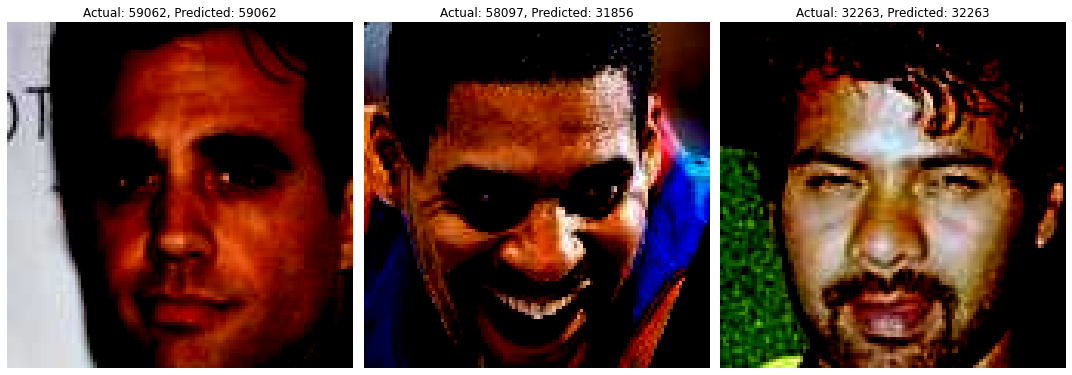

In [79]:
make_predictions(model, test_dl)

### Dummy code

In [ ]:
!stop

#### Loss Function checking

In [ ]:
k = nn.Parameter(torch.FloatTensor(3, 5))
k

In [ ]:
a = torch.Tensor([[1, 2, 3], [3, -4, -2]])
b = torch.Tensor([[1, 2, 3, 4], [3, 4, 1, 0], [5, 6, 1, 1]])

In [ ]:
a = torch.FloatTensor([1, 2])

In [ ]:
a.dtype

In [ ]:
c = torch.mm(a, b)
c.shape

In [ ]:
c

In [ ]:
c.size()

In [ ]:
e = c.clamp(-1, 1)

In [ ]:
e

In [ ]:
dirty = e > 0
dirty

In [ ]:
dirty = dirty.float()
dirty

In [ ]:
index = torch.where(c != -1)[0]
index

In [ ]:
index.size(0)

In [ ]:
index.size()[0]

In [ ]:
torch.zeros(index.size()[0], c.size()[1])

In [ ]:
def abc(a: int, logits):# torch.Tensor):
    print(a)
    print(logits)

In [ ]:
abc(5, c)

In [ ]:
k = [[1, 2, 3], [2, 3, 1]]
abc(5, k)

In [ ]:
k = [[1, 2, 3], [2, 3, 1]]
abc(5.2, 4)

In [ ]:
c.view(-1)

In [ ]:
#----

In [ ]:
logits = torch.Tensor([[1, 0, 0, 0], [0, 1, 1, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1, 0, 0, 0]]) #torch.Tensor([10, 2, 3, 5])
labels = torch.Tensor([[1, 0, 0, 0], [0, 1, 1, 0], [0, 1, 0, 1], [0, 0, 0, 1]])

index = torch.where(labels != -1)[0]
index

In [ ]:
print(logits.dtype)
print(labels.dtype)
print(index.dtype)

In [ ]:
labels[index]

In [ ]:
l = labels[index].view(-1)
l

In [ ]:
l = l.int()
l

In [ ]:
t = logits[index, index]

In [ ]:
t

#### Dataset preprocessing checking

##### For Windows system

In [ ]:
# path_imgidx = 'D:/Face/faces_emore/train.idx'
# path_imgrec = 'D:/Face/faces_emore/train.rec'
# imgrec = recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')

# len(imgrec.keys)

##### For Ubuntu system

In [ ]:
path_imgidx = '../faces_emore/train.idx'
path_imgrec = '../faces_emore/train.rec'
imgrec = recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')

len(imgrec.keys)

In [ ]:
imgrec.keys

In [ ]:
list(imgrec.keys)

In [ ]:
np.array(list(imgrec.keys))

In [ ]:
len(np.array(list(imgrec.keys)))

In [ ]:
img_list = []

#%% 1 ~ 5908396, or 0~5908395, #85742 identities

for i in range(5822653):
    header, s = recordio.unpack(imgrec.read_idx(i+1))
#     img = mx.image.imdecode(s).asnumpy() 
#     plt.imshow(img)
#     print(img.shape)
#     plt.title('id=' + str(i) + ', label=' + str(header.label))
#     plt.pause(0.1)
    img_list.append(header.label)

In [ ]:
len(img_list)

In [ ]:
# img_list = np.array(img_list)
# print(np.unique(img_list))

In [ ]:
_img_list = img_list[0:5822653]
__img_list = np.array(_img_list)
print(len(__img_list))
print(len(np.unique(__img_list)))

In [ ]:
# res_list = []

# for item in _img_list:
#     if item not in res_list:
#         res_list.append(item)

# print("Unique elements of the list using append():")
# print(len(res_list))

# #for item in res_list: 
# #    print(item)

In [ ]:
5908395 - 5822653

In [ ]:
img_list[5822653]

In [ ]:
img_list[5822654]

In [ ]:
idx1 = 1000 #5908395
header1, s1 = recordio.unpack(imgrec.read_idx(idx1))

img1 = mx.image.imdecode(s1).asnumpy()
plt.imshow(img1)
plt.title('id=' + str(idx1) + ', label=' + str(header1.label))

In [ ]:
idx = 5822656
header, s = recordio.unpack(imgrec.read_idx(idx))

#img = mx.image.imdecode(s).asnumpy()
#plt.imshow(img)
plt.title('id=' + str(idx) + ', label=' + str(header.label))

In [ ]:
header.flag

In [ ]:
header.label

In [ ]:
header0 = (int(header.label[0]), int(header.label[1]))
header0

In [ ]:
np.array(range(1, int(header.label[0])))

In [ ]:
len(np.array(range(1, int(header.label[0]))))

In [ ]:
len(np.array(range(1, int(header.label[1]))))

In [ ]:
class Sub:
    def __init__(self, name):
        super(Sub, self).__init__() #Another way to fix  this
        self.name=name
        

a = Sub("Harry")
a.name

In [ ]:
isinstance([1, 2], numbers.Number)

In [ ]:
a = torch.tensor(65.5, dtype=torch.long)
a

#### Training checking

In [ ]:
temp = torch.zeros(85742)
#temp[idx] = 1
#temp

In [ ]:
temp_labels = torch.Tensor([5, 5, 1, 0]) #batchsize=4
print(temp_labels)
print(temp_labels[0])

temp = torch.zeros(4, 6) #no.of classes=6 : [0-5]
#temp[int(temp_labels[0])] = 1
print(temp.shape)

In [ ]:
c = 0
for i in temp_labels:
    #print(i)
    #print(c)
    temp[c][int(i)] = 1
    c+=1

In [ ]:
temp

#### Training Accuracy checking

In [ ]:
a = torch.Tensor([[1, 2, 33, -4, -2, 1], [5, 55, 1, -4, 0, 56]])
b = torch.Tensor([2, 5])

c = accuracy(a, b)
print(c)

In [ ]:
_, preds = torch.max(a, dim=1)
preds

In [ ]:
d = torch.sum(preds == b)
d.item()